# Question Answering

## Overview

Recall the overall workflow for retrieval augmented generation (RAG):

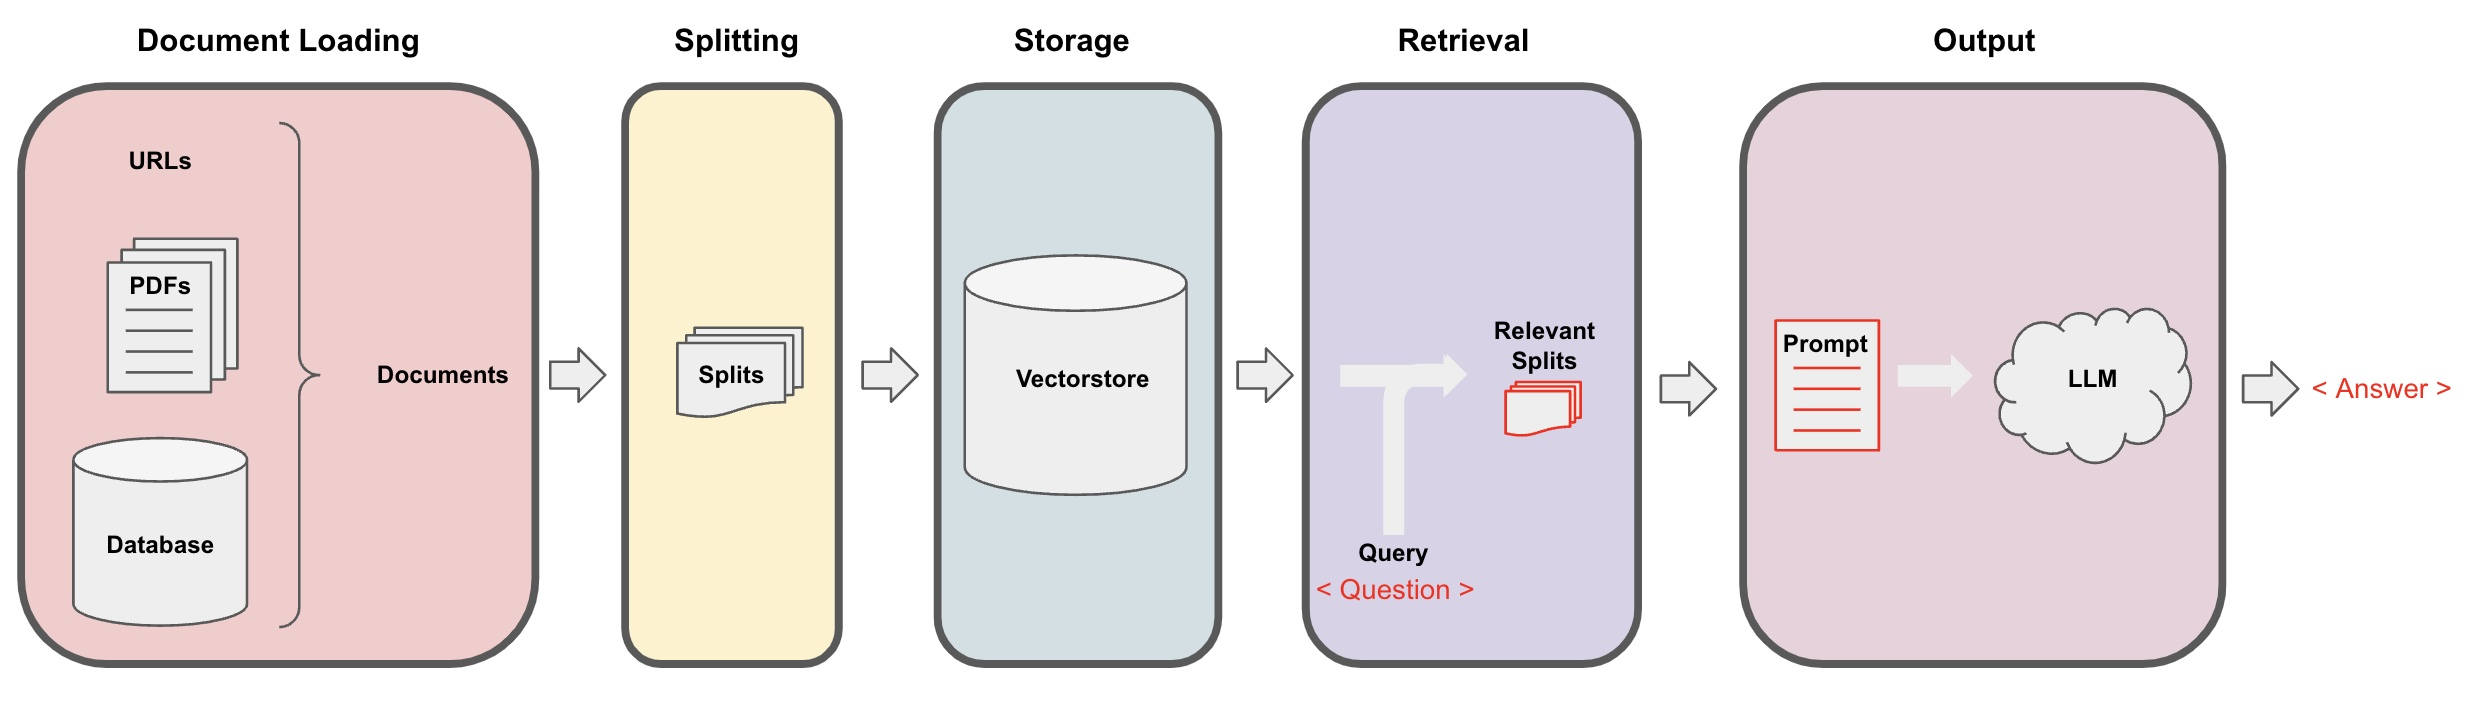

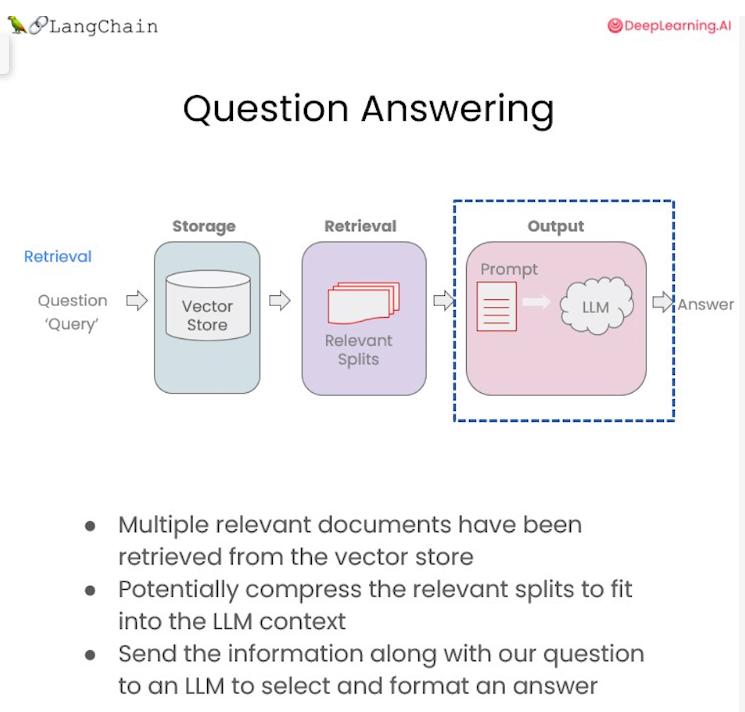

###########################################################################################

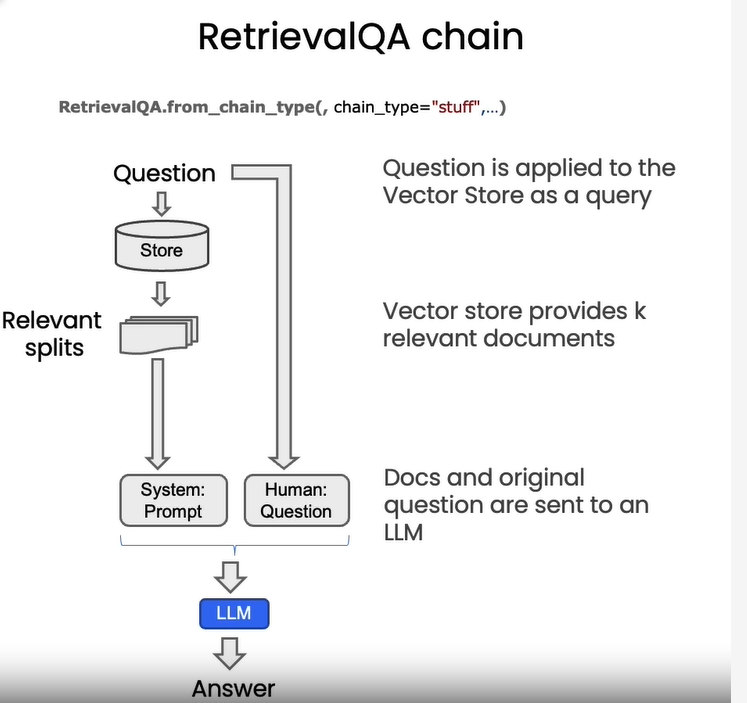

###########################################################################################

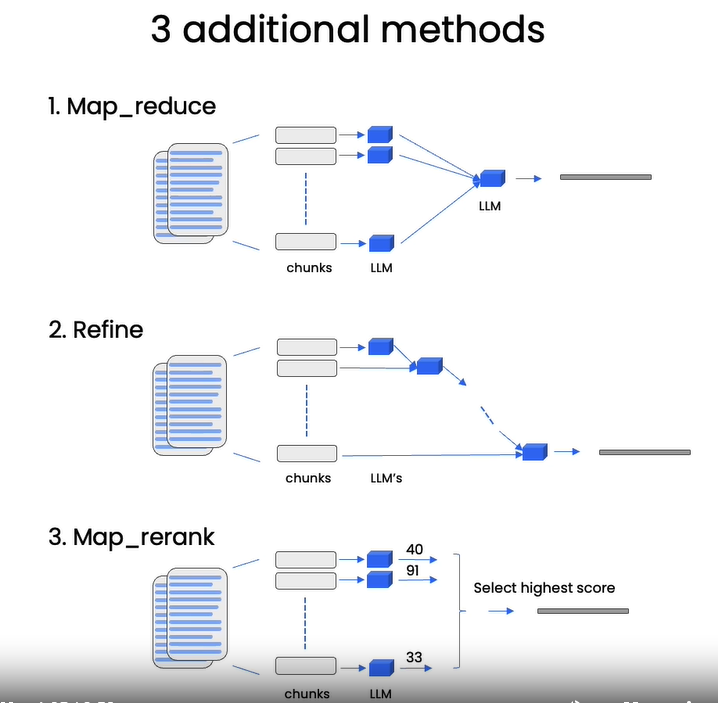

We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

Let's load our vectorDB. 

In [ ]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

The code below was added to assign the openai LLM version filmed until it is deprecated, currently in Sept 2023. 
LLM responses can often vary, but the responses may be significantly different when using a different model version.

In [ ]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [ ]:
print(vectordb._collection.count())

In [ ]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

In [ ]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0)

### RetrievalQA chain

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [ ]:
result = qa_chain({"query": question})

In [ ]:
result["result"]

### Prompt

In [ ]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)


In [ ]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [ ]:
question = "Is probability a class topic?"

In [ ]:
result = qa_chain({"query": question})

In [ ]:
result["result"]

In [ ]:
result["source_documents"][0]

### RetrievalQA chain types

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [ ]:
result = qa_chain_mr({"query": question})

In [ ]:
result["result"]

If you wish to experiment on the `LangChain plus platform`:

 * Go to [langchain plus platform](https://www.langchain.plus/) and sign up
 * Create an API key from your account's settings
 * Use this API key in the code below   
 * uncomment the code  
 Note, the endpoint in the video differs from the one below. Use the one below.

In [ ]:
#import os
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
#os.environ["LANGCHAIN_API_KEY"] = "..." # replace dots with your api key

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)
result = qa_chain_mr({"query": question})
result["result"]

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine"
)
result = qa_chain_mr({"query": question})
result["result"]

### RetrievalQA limitations
 
QA fails to preserve conversational history.

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [ ]:
question = "Is probability a class topic?"
result = qa_chain({"query": question})
result["result"]

In [ ]:
question = "why are those prerequesites needed?"
result = qa_chain({"query": question})
result["result"]

Note, The LLM response varies. Some responses **do** include a reference to probability which might be gleaned from referenced documents. The point is simply that the model does not have access to past questions or answers, this will be covered in the next section.